In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [4]:
models = [
    TwoOsillators(strengthLambda=1, distanceD0=0.25, omega1=3, omega2=-3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.5, omega1=3, omega2=-3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.75, omega1=2.75, omega2=-3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.5, omega1=2.5, omega2=-3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.5, omega1=2, omega2=3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.55, omega1=2, omega2=3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.45, omega1=2.25, omega2=3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=1, distanceD0=0.45, omega1=2.5, omega2=3, dt=0.001, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
]
# for model in models[2:4]:
#     model.run(300000)

300001
300001


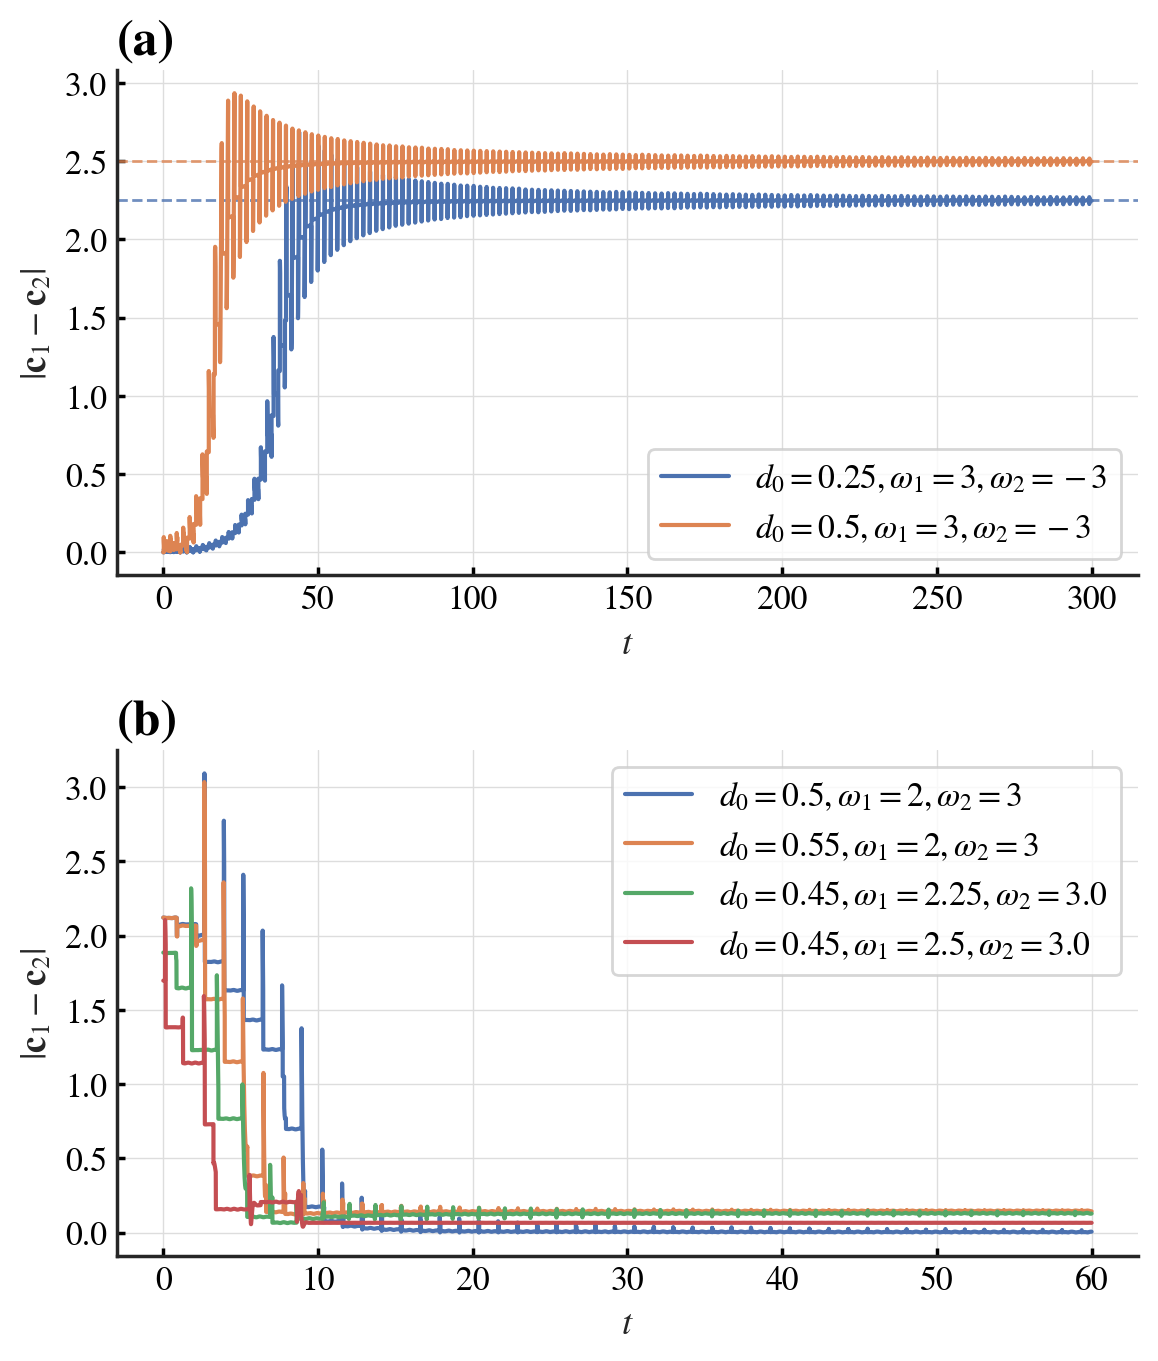

In [7]:
def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        omegaTheta = model.omegaTheta
        # center = np.array([
        #     positionx - 3 / omegaTheta * np.sin(sa.totalPhaseTheta[i, :]),
        #     positiony + 3 / omegaTheta * np.cos(sa.totalPhaseTheta[i, :])
        # ]).T
        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:2]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    print(TNum)
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    omega1, omega2 = model.omegaTheta
    x = np.arange(len(distance)) * model.dt
    ax1.plot(x, distance, color=f"C{colorIdx}",
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    ax1.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
               color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
    colorIdx += 1

# ax1.set_ylim(0, 4)
ax1.legend(frameon=True)
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax1.tick_params(direction='in', length=3)
ax1.grid(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)

colorIdx = 0
for model in models[4:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    omega1, omega2 = model.omegaTheta
    x = np.arange(len(distance)) * model.dt
    ax2.plot(x, distance, color=f"C{colorIdx}",
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    colorIdx += 1

# ax2.set_ylim(0, 3.5)
ax2.legend(frameon=True)
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax2.tick_params(direction='in', length=3)
ax2.grid(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
# plt.savefig("./PJT_C_Fig/2OsCenterDistance.pdf", bbox_inches="tight")

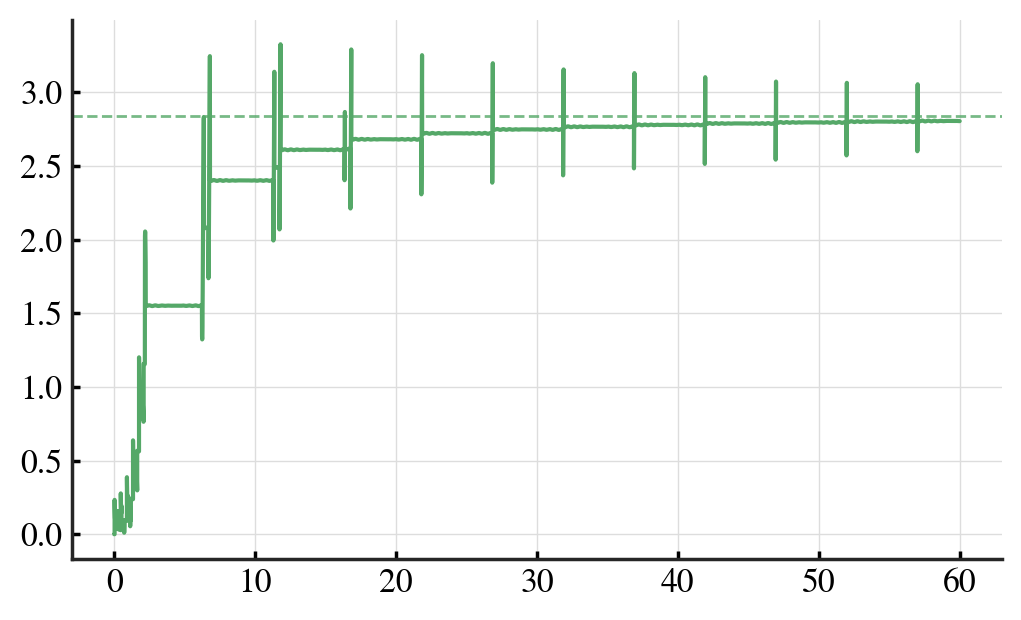

In [36]:
plt.subplots(1, 1, figsize=(6, 3.5))
colorIdx = 2
for model in models[2:3]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    omega1, omega2 = model.omegaTheta
    x = np.arange(len(distance)) * model.dt
    plt.plot(x, distance, color=f"C{colorIdx}",
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    plt.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
               color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
    colorIdx += 1

plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

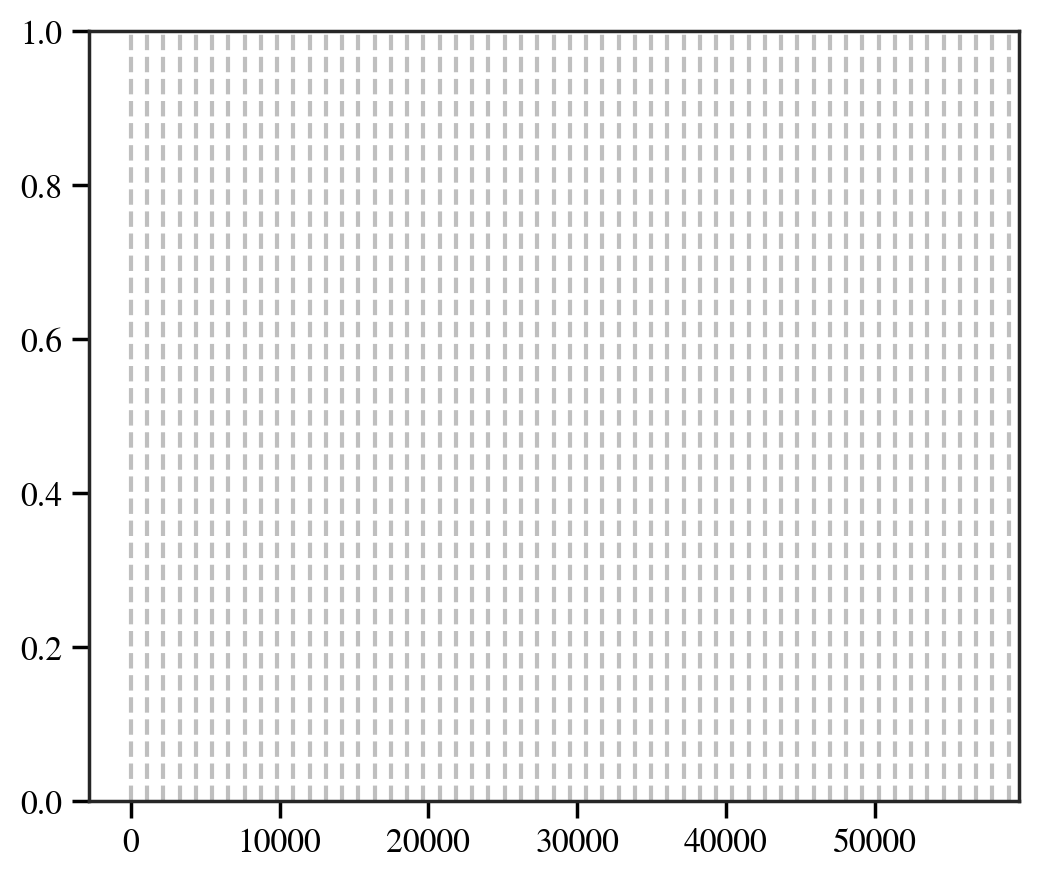

In [37]:
absOmega = model.omegaTheta
deltaOmega = max(absOmega) - min(absOmega)
duration = np.pi * 2 / (deltaOmega * model.dt)
for idx in np.arange(0, len(distance), duration):  # * model.dt
    plt.axvline(idx, color="gray", linestyle="--", alpha=0.5)

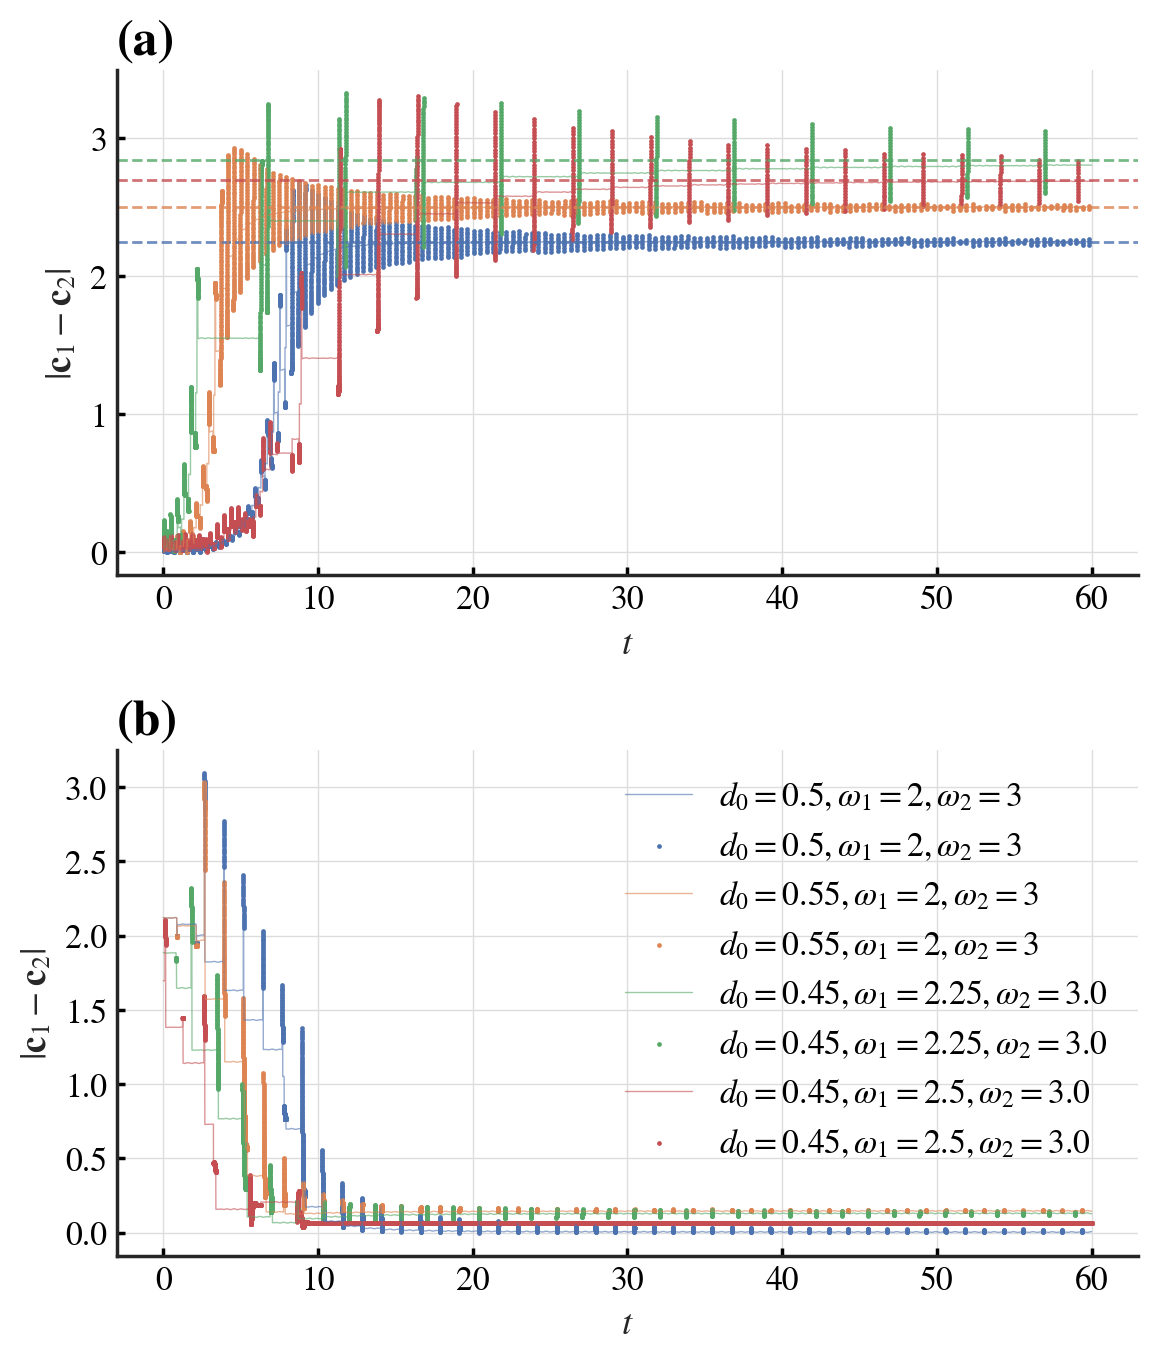

In [8]:
def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        omegaTheta = model.omegaTheta
        # center = np.array([
        #     positionx - 3 / omegaTheta * np.sin(sa.totalPhaseTheta[i, :]),
        #     positiony + 3 / omegaTheta * np.cos(sa.totalPhaseTheta[i, :])
        # ]).T
        speedConst = model.speedV * model.dt
        center = np.array([
            positionx - speedConst / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + speedConst / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:4]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    OSdis = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = OSdis <= model.distanceD0
    omega1, omega2 = model.omegaTheta
    ax1.plot(np.arange(len(distance)) * model.dt, distance, color=f"C{colorIdx}", lw=0.5, alpha=0.6,
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    distance[~Aij] = np.nan
    ax1.scatter(np.arange(len(distance)) * model.dt, distance, color=f"C{colorIdx}", s=0.5,
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    ax1.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
               color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
    colorIdx += 1

# ax1.set_ylim(0, 4)
# ax1.legend(frameon=False)
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax1.tick_params(direction='in', length=3)
ax1.grid(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)

colorIdx = 0
for model in models[4:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    OSdis = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = OSdis <= model.distanceD0
    omega1, omega2 = model.omegaTheta
    ax2.plot(np.arange(len(distance)) * model.dt, distance, color=f"C{colorIdx}", lw=0.5, alpha=0.6,
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    distance[~Aij] = np.nan
    ax2.scatter(np.arange(len(distance)) * model.dt, distance, color=f"C{colorIdx}", s=0.5,
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    colorIdx += 1

# ax2.set_ylim(0, 3.5)
ax2.legend(frameon=False)
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax2.tick_params(direction='in', length=3)
ax2.grid(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
# plt.savefig("./PJT_C_Fig/2OsCenterDistance.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


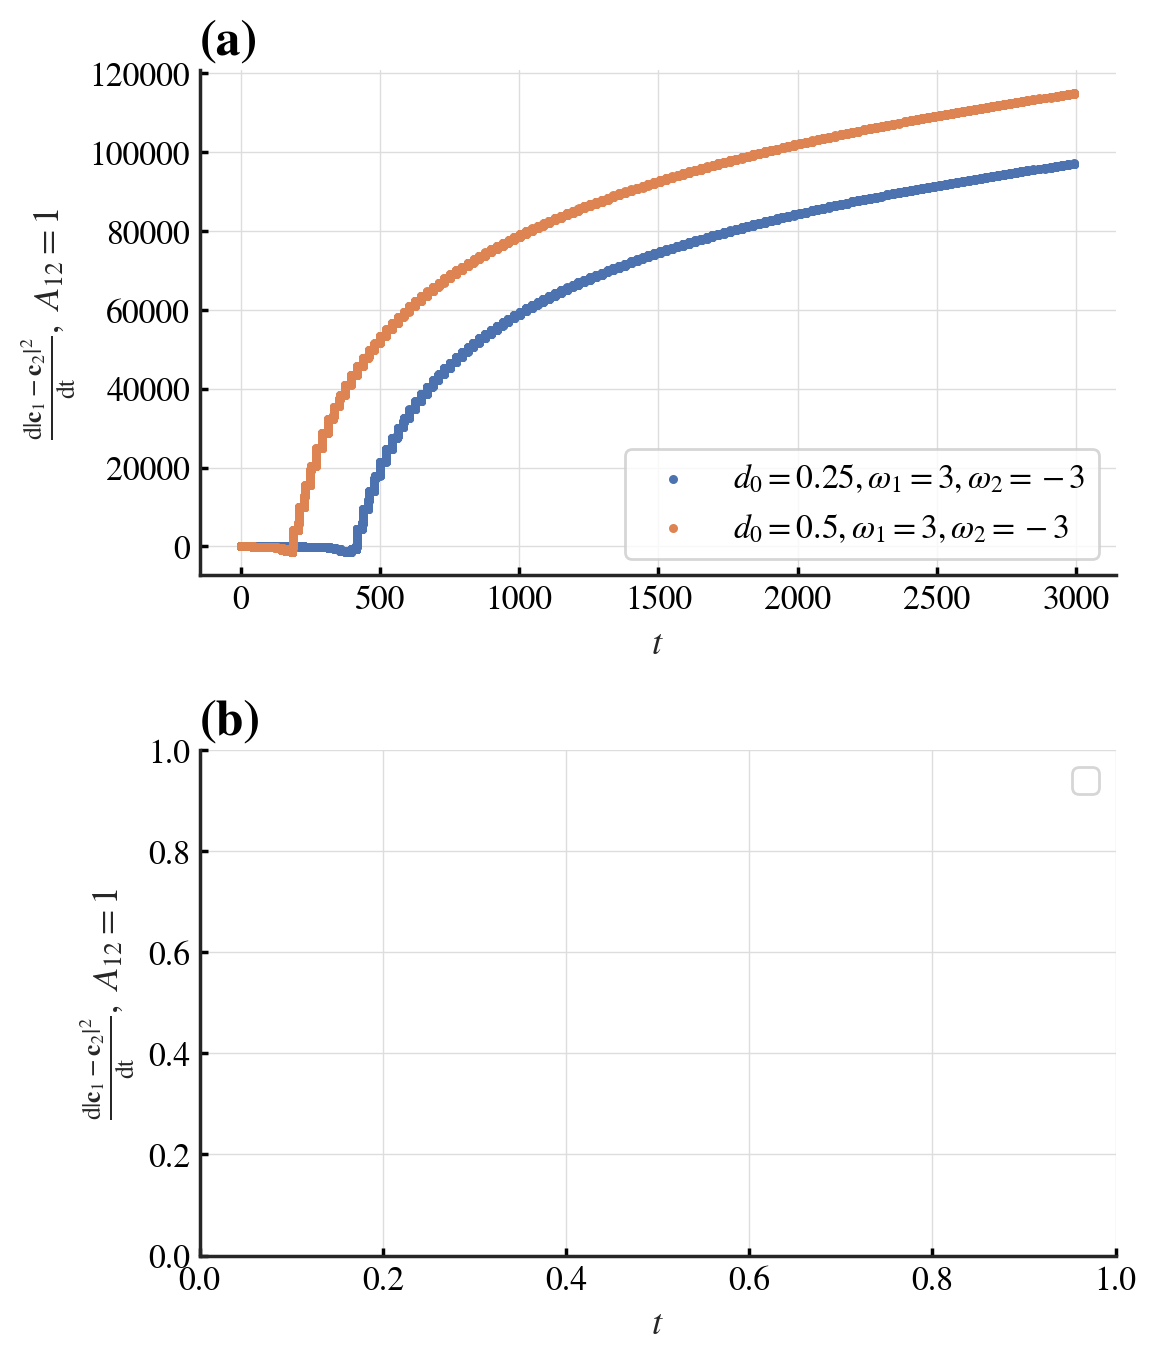

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:2]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta[0] = np.nan
    distance = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = distance <= model.distanceD0
    speedConst = model.speedV * model.dt
    deltax = totalPositionX[:, 0, 0] - totalPositionX[:, 1, 0]
    deltay = totalPositionX[:, 0, 1] - totalPositionX[:, 1, 1]
    # assert 0
    deltaX = (
        deltax - speedConst * 
        (
            np.sin(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.sin(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaX[0] = 0
    deltaY = (
        deltay + speedConst *
        (
            np.cos(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.cos(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaY[0] = 0
    ddotTheta = (
        model.strengthLambda * Aij[:, np.newaxis] * 
        (totalPointTheta[:, ::-1] - totalPointTheta) * 
        np.cos(totalPhaseTheta[:, ::-1] - totalPhaseTheta)
    )
    dotDeltaX = (
        speedConst * (
            np.sin(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2 - 
            np.sin(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
        )
    )
    dotDeltaX[0] = 0
    dotDeltaY = (
        speedConst * (
            - np.cos(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
            + np.cos(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2
        )
    )
    dotDeltaY[0] = 0
    part1 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.sin(totalPhaseTheta)
    part1[np.isnan(part1)] = 0
    part1 = (part1[:, 0] - part1[:, 1]) * deltax
    part2 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.cos(totalPhaseTheta)
    part2[np.isnan(part2)] = 0
    part2 = (- part2[:, 0] + part2[:, 1]) * deltay
    part3 = -2 * speedConst**2 * (ddotTheta / totalPointTheta**3).sum(axis=1)
    part3[np.isnan(part3)] = 0
    part4 = (
        2 * speedConst**2 / totalPointTheta[:, 0] / totalPointTheta[:, 1] * 
        (ddotTheta / totalPointTheta).sum(axis=1) * 
        np.cos(totalPhaseTheta[:, 0] - totalPhaseTheta[:, 1])
    )
    part4[np.isnan(part4)] = 0
    
    color = "C1" if model.omegaTheta[0] * model.omegaTheta[1] < 0 else "C2"

    x = np.arange(len(distance)) * 0.01

    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    # value = deltaX * dotDeltaX + deltaY * dotDeltaY
    value = np.cumsum(part1 + part2 + part3 + part4)
    # value = np.sqrt(distance[0] + np.cumsum(part1 + part2 + part3 + part4) * 0.01)
    value[~Aij] = np.nan
    idx = models.index(model)
    omega1, omega2 = model.omegaTheta
    if idx < 4:
        ax1.scatter(x, value, s=5,
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    else:
        ax2.scatter(x, value, s=5,
                    label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    # ax.plot(x, np.cumsum(part3) * 0.01, color=color)
    # print(min(np.cumsum(part1 + part2) * 0.01))

for ax in axs:
    # ax.set_ylim(-1, 1.01)
    ax.legend(frameon=True)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\frac{\mathrm{d}\left| \mathbf{c}_1-\mathbf{c}_2 \right|^2}{\mathrm{dt}},\ A_{12} = 1$")
    ax.tick_params(direction='in', length=3)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=3)

ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()

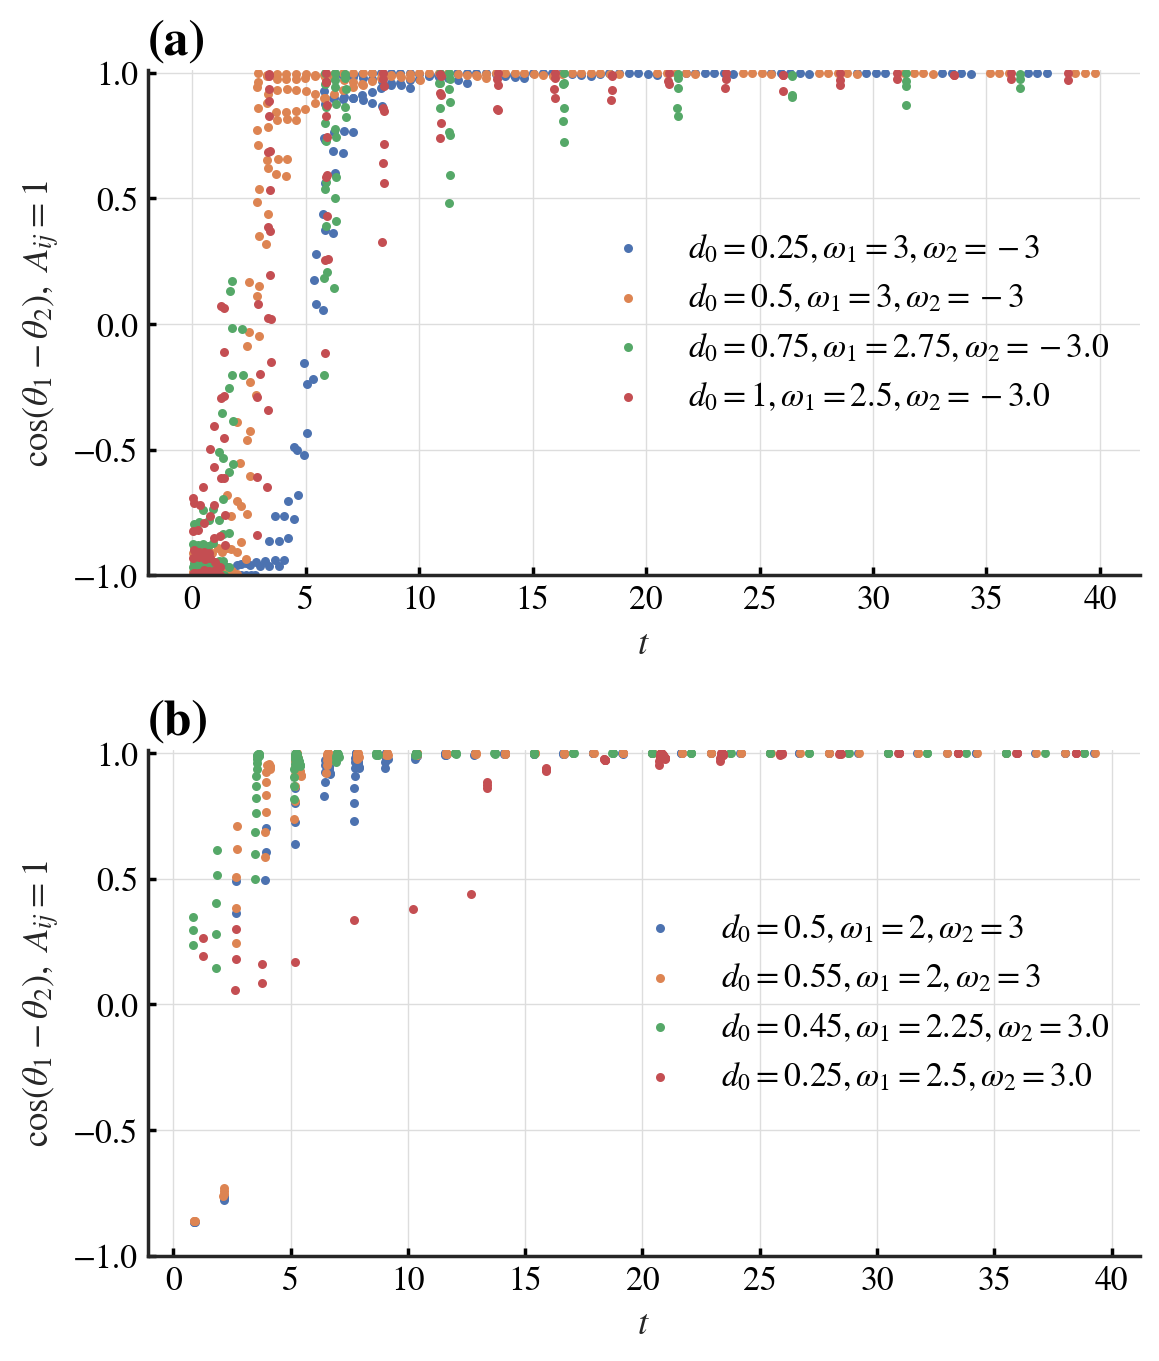

In [141]:
def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        omegaTheta = model.omegaTheta
        # center = np.array([
        #     positionx - 3 / omegaTheta * np.sin(sa.totalPhaseTheta[i, :]),
        #     positiony + 3 / omegaTheta * np.cos(sa.totalPhaseTheta[i, :])
        # ]).T
        center = np.array([
            positionx - 0.03 / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + 0.03 / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta[0] = np.nan
    distance = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = distance <= model.distanceD0
    deltax = totalPositionX[:, 0, 0] - totalPositionX[:, 1, 0]
    deltay = totalPositionX[:, 0, 1] - totalPositionX[:, 1, 1]
    deltaX = (
        deltax - 0.03 * 
        (
            np.sin(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.sin(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaX[0] = 0
    deltaY = (
        deltay + 0.03 *
        (
            np.cos(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.cos(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaY[0] = 0
    ddotTheta = (
        model.strengthLambda * Aij[:, np.newaxis] * 
        (totalPointTheta[:, ::-1] - totalPointTheta) * 
        np.cos(totalPhaseTheta[:, ::-1] - totalPhaseTheta)
    )
    dotDeltaX = (
        0.03 * (
            np.sin(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2 - 
            np.sin(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
        )
    )
    dotDeltaX[0] = 0
    dotDeltaY = (
        0.03 * (
            - np.cos(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
            + np.cos(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2
        )
    )
    dotDeltaY[0] = 0
    part1 = 2 * 0.03 * ddotTheta / totalPointTheta**2 * np.sin(totalPhaseTheta)
    part1[np.isnan(part1)] = 0
    part1 = (part1[:, 0] - part1[:, 1]) * deltax
    part2 = 2 * 0.03 * ddotTheta / totalPointTheta**2 * np.cos(totalPhaseTheta)
    part2[np.isnan(part2)] = 0
    part2 = (- part2[:, 0] + part2[:, 1]) * deltay
    part3 = -2 * 0.03**2 * (ddotTheta / totalPointTheta**3).sum(axis=1)
    part3[np.isnan(part3)] = 0
    part4 = (
        2 * 0.03**2 / totalPointTheta[:, 0] / totalPointTheta[:, 1] * 
        (ddotTheta / totalPointTheta).sum(axis=1) * 
        np.cos(totalPhaseTheta[:, 0] - totalPhaseTheta[:, 1])
    )
    part4[np.isnan(part4)] = 0
    
    color = "C1" if model.omegaTheta[0] * model.omegaTheta[1] < 0 else "C2"

    x = np.arange(len(distance)) * 0.01
    # ax.plot(x, np.cumsum(2 * deltaX * dotDeltaX + 2 * deltaY * dotDeltaY), color=color)
    # ax.plot(x, np.cumsum(deltaX * dotDeltaX + dotDeltaY * deltaY))
    # ax.scatter(x, part1 + part2, s=5, color="C0")
    # ax.scatter(x, part3 + part4, s=5, color="C1")
    # ax.scatter(x, np.abs(part3 + part4) - np.abs(part1 + part2), s=5, color="C1")
    # ax.scatter(x, np.abs(part3), s=5, color="C0")
    deltaPhase = np.cos(totalPhaseTheta[:, 1] - totalPhaseTheta[:, 0])
    deltaPhase[~Aij] = np.nan
    idx = models.index(model)
    omega1, omega2 = model.omegaTheta
    if idx < 4:
        ax1.scatter(x, deltaPhase, s=5,
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    else:
        ax2.scatter(x, deltaPhase, s=5,
                    label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    # ax.plot(x, np.cumsum(part3) * 0.01, color=color)
    # print(min(np.cumsum(part1 + part2) * 0.01))

for ax in axs:
    ax.set_ylim(-1, 1.01)
    ax.legend(loc="center right", frameon=False)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\cos(\theta_1-\theta_2),\ A_{ij} = 1$")
    ax.tick_params(direction='in', length=3)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=3)

ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/2OsCosDeltaTheta.pdf", bbox_inches="tight")

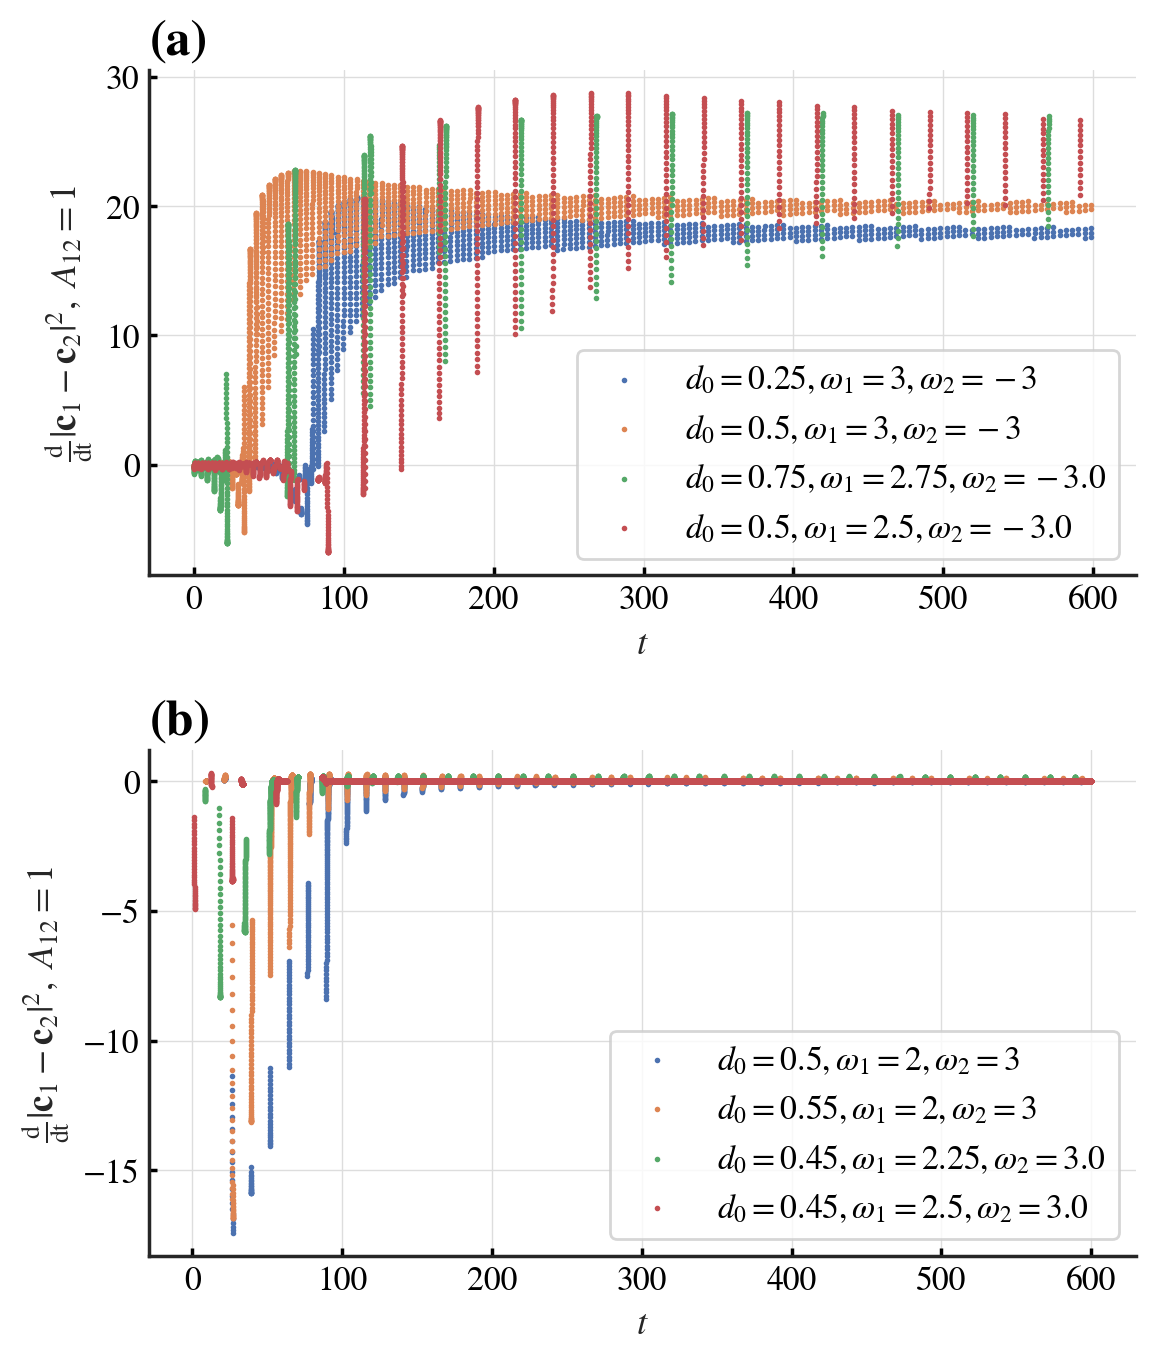

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta[0] = np.nan
    distance = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = distance <= model.distanceD0
    speedConst = model.speedV * model.dt
    deltax = totalPositionX[:, 0, 0] - totalPositionX[:, 1, 0]
    deltay = totalPositionX[:, 0, 1] - totalPositionX[:, 1, 1]
    deltaX = (
        deltax - speedConst * 
        (
            np.sin(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.sin(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaX[0] = 0
    deltaY = (
        deltay + speedConst *
        (
            np.cos(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.cos(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaY[0] = 0
    ddotTheta = (
        model.strengthLambda * Aij[:, np.newaxis] * 
        (totalPointTheta[:, ::-1] - totalPointTheta) * 
        np.cos(totalPhaseTheta[:, ::-1] - totalPhaseTheta)
    )
    dotDeltaX = (
        speedConst * (
            np.sin(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2 - 
            np.sin(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
        )
    )
    dotDeltaX[0] = 0
    dotDeltaY = (
        speedConst * (
            - np.cos(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
            + np.cos(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2
        )
    )
    dotDeltaY[0] = 0
    part1 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.sin(totalPhaseTheta)
    part1[np.isnan(part1)] = 0
    part1 = (part1[:, 0] - part1[:, 1]) * deltax
    part2 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.cos(totalPhaseTheta)
    part2[np.isnan(part2)] = 0
    part2 = (- part2[:, 0] + part2[:, 1]) * deltay
    part3 = -2 * speedConst**2 * (ddotTheta / totalPointTheta**3).sum(axis=1)
    part3[np.isnan(part3)] = 0
    part4 = (
        2 * speedConst**2 / totalPointTheta[:, 0] / totalPointTheta[:, 1] * 
        (ddotTheta / totalPointTheta).sum(axis=1) * 
        np.cos(totalPhaseTheta[:, 0] - totalPhaseTheta[:, 1])
    )
    part4[np.isnan(part4)] = 0
    
    color = "C1" if model.omegaTheta[0] * model.omegaTheta[1] < 0 else "C2"

    x = np.arange(len(distance)) * 0.01

    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    value = part1 + part2 + part3 + part4
    # value = np.sqrt(distance[0] + np.cumsum(part1 + part2 + part3 + part4) * 0.01)
    value[~Aij] = np.nan
    idx = models.index(model)
    omega1, omega2 = model.omegaTheta
    if idx < 4:
        ax1.scatter(x, value, s=1,
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    else:
        ax2.scatter(x, value, s=1,
                    label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    # ax.plot(x, np.cumsum(part3) * 0.01, color=color)
    # print(min(np.cumsum(part1 + part2) * 0.01))

for ax in axs:
    # ax.set_ylim(-1, 1.01)
    ax.legend(frameon=True)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\frac{\mathrm{d}}{\mathrm{dt}}\left| \mathbf{c}_1-\mathbf{c}_2 \right|^2,\ A_{12} = 1$")
    ax.tick_params(direction='in', length=3)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=3)

ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/2OsDotDistance.pdf", bbox_inches="tight")

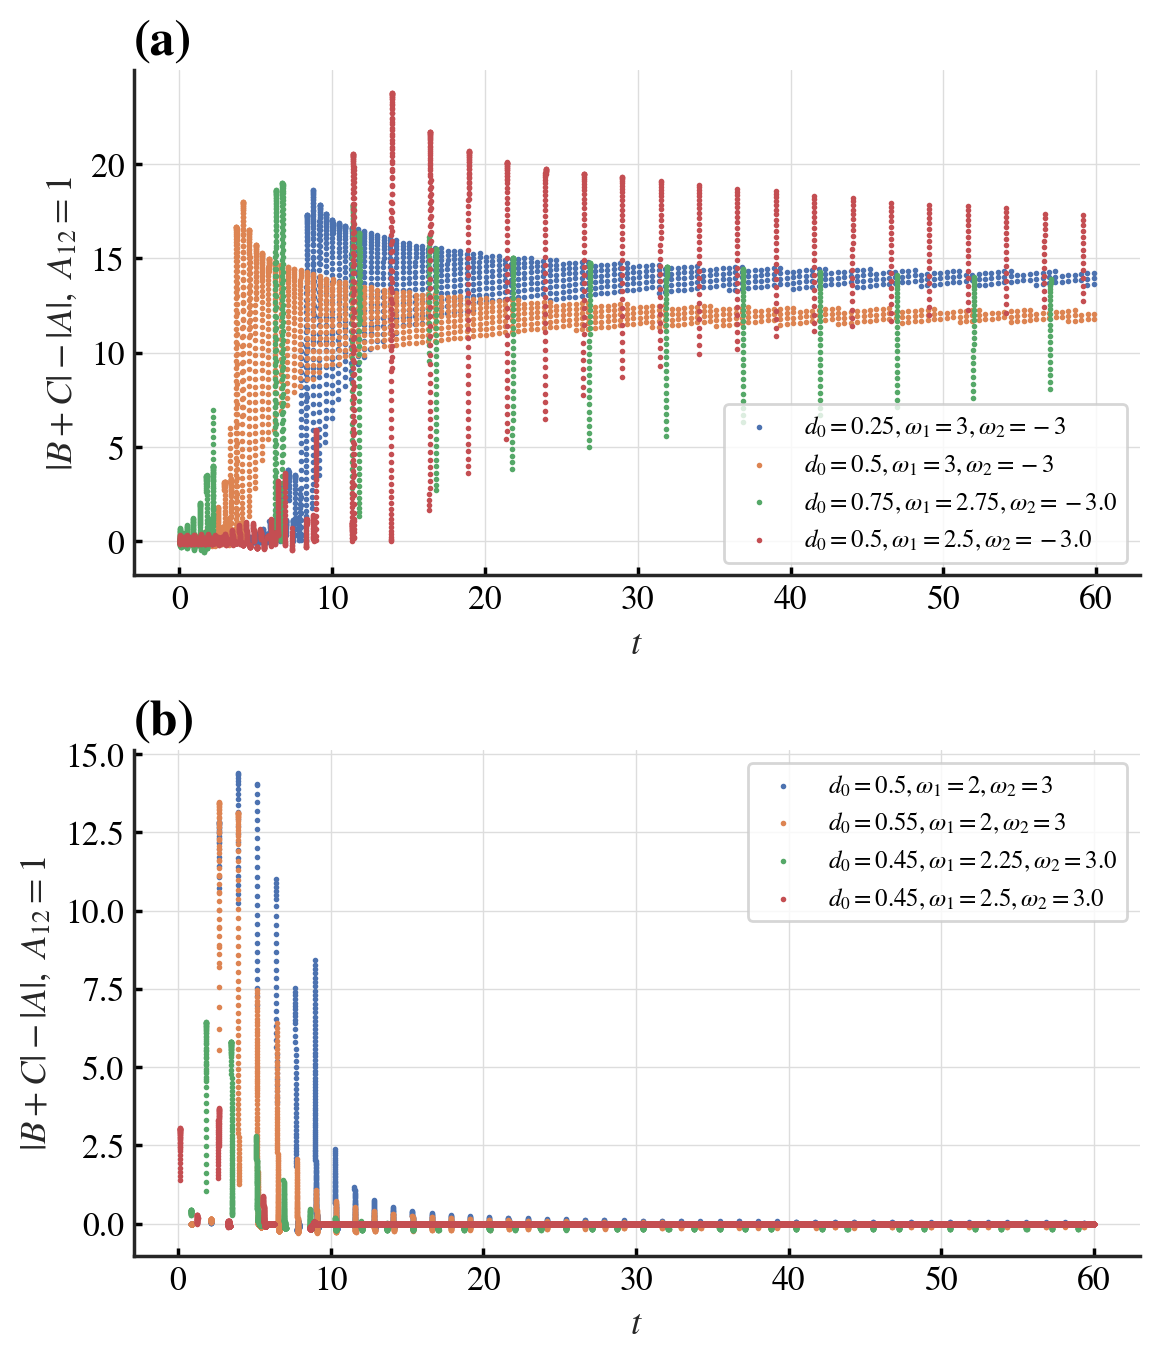

In [6]:
def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        omegaTheta = model.omegaTheta
        # center = np.array([
        #     positionx - 3 / omegaTheta * np.sin(sa.totalPhaseTheta[i, :]),
        #     positiony + 3 / omegaTheta * np.cos(sa.totalPhaseTheta[i, :])
        # ]).T
        center = np.array([
            positionx - 0.03 / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + 0.03 / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta[0] = np.nan
    distance = np.sqrt(np.sum((totalPositionX[:, 0] - totalPositionX[:, 1]) ** 2, axis=1))
    Aij = distance <= model.distanceD0
    deltax = totalPositionX[:, 0, 0] - totalPositionX[:, 1, 0]
    deltay = totalPositionX[:, 0, 1] - totalPositionX[:, 1, 1]
    speedConst = model.speedV * model.dt
    deltaX = (
        deltax - speedConst * 
        (
            np.sin(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.sin(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaX[0] = 0
    deltaY = (
        deltay + speedConst *
        (
            np.cos(totalPhaseTheta[:, 0]) / totalPointTheta[:, 0] - 
            np.cos(totalPhaseTheta[:, 1]) / totalPointTheta[:, 1]
        )
    )
    deltaY[0] = 0
    ddotTheta = (
        model.strengthLambda * Aij[:, np.newaxis] * 
        (totalPointTheta[:, ::-1] - totalPointTheta) * 
        np.cos(totalPhaseTheta[:, ::-1] - totalPhaseTheta)
    )
    dotDeltaX = (
        speedConst * (
            np.sin(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2 - 
            np.sin(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
        )
    )
    dotDeltaX[0] = 0
    dotDeltaY = (
        speedConst * (
            - np.cos(totalPhaseTheta[:, 1]) * ddotTheta[:, 0] / totalPointTheta[:, 1]**2
            + np.cos(totalPhaseTheta[:, 0]) * ddotTheta[:, 0] / totalPointTheta[:, 0]**2
        )
    )
    dotDeltaY[0] = 0
    part1 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.sin(totalPhaseTheta)
    part1[np.isnan(part1)] = 0
    part1 = (part1[:, 0] - part1[:, 1]) * deltax
    part2 = 2 * speedConst * ddotTheta / totalPointTheta**2 * np.cos(totalPhaseTheta)
    part2[np.isnan(part2)] = 0
    part2 = (- part2[:, 0] + part2[:, 1]) * deltay
    part3 = -2 * speedConst**2 * (ddotTheta / totalPointTheta**3).sum(axis=1)
    part3[np.isnan(part3)] = 0
    part4 = (
        2 * speedConst**2 / totalPointTheta[:, 0] / totalPointTheta[:, 1] * 
        (ddotTheta / totalPointTheta).sum(axis=1) * 
        np.cos(totalPhaseTheta[:, 0] - totalPhaseTheta[:, 1])
    )
    part4[np.isnan(part4)] = 0
    
    color = "C1" if model.omegaTheta[0] * model.omegaTheta[1] < 0 else "C2"

    x = np.arange(len(distance)) * model.dt
    # ax.plot(x, np.cumsum(2 * deltaX * dotDeltaX + 2 * deltaY * dotDeltaY), color=color)
    # ax.plot(x, np.cumsum(deltaX * dotDeltaX + dotDeltaY * deltaY))
    # ax.scatter(x, part1 + part2, s=5, color="C0")
    # ax.scatter(x, part3 + part4, s=5, color="C1")
    # ax.scatter(x, np.abs(part3 + part4) - np.abs(part1 + part2), s=5, color="C1")
    # ax.scatter(x, np.abs(part3), s=5, color="C0")
    value1 = part1 + part2
    value1[~Aij] = np.nan
    value2 = part3 + part4
    value2[~Aij] = np.nan
    idx = models.index(model)
    omega1, omega2 = model.omegaTheta
    if idx < 4:
        ax1.scatter(x, np.abs(value2) - np.abs(value1), s=1, color=f"C{idx}",
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    else:
        ax2.scatter(x, np.abs(value2) - np.abs(value1), s=1, color=f"C{idx - 4}",
                label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    # ax.plot(x, np.cumsum(part3) * 0.01, color=color)
    # print(min(np.cumsum(part1 + part2) * 0.01))

for ax in axs:
    # ax.set_ylim(-1, 1.01)
    ax.legend(frameon=True, fontsize=9)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$|B+C|-|A|,\ A_{12} = 1$")
    ax.tick_params(direction='in', length=3)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=3)

ax1.legend(frameon=True, fontsize=9)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/2OsBCsubA.pdf", bbox_inches="tight")

In [43]:
deltaPhase

array([0., 0., 0., ..., 0., 0., 0.])

(0.0, 10.0)

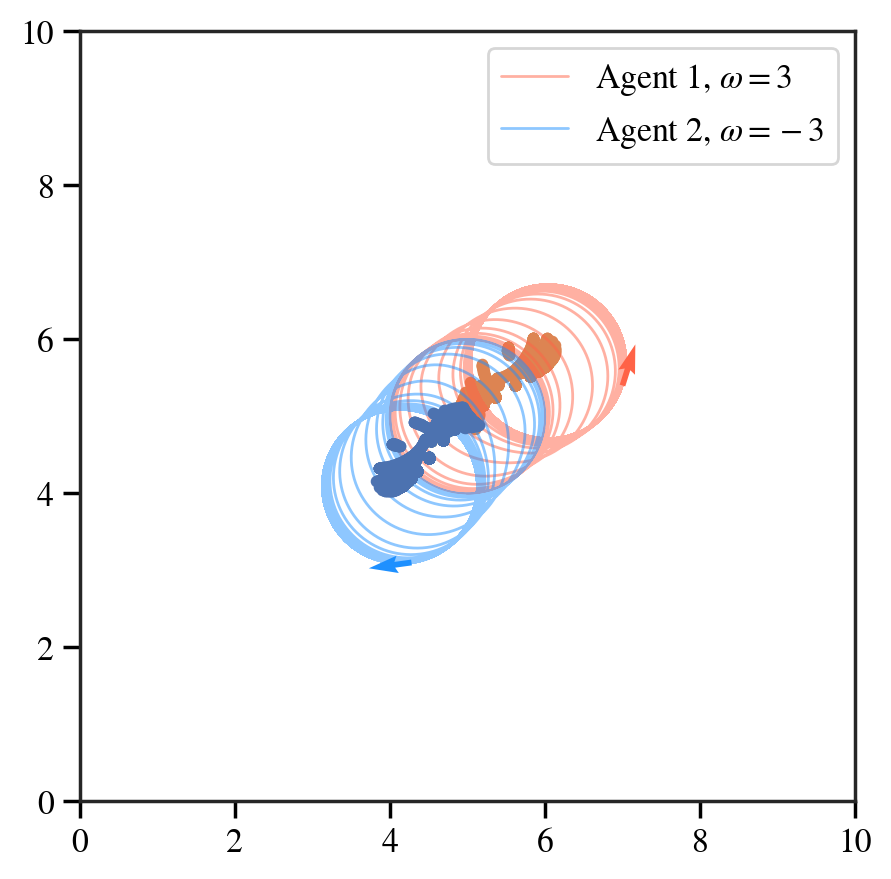

In [18]:
model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.5, lw=1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=10, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=10
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

plt.xlim(0, 10)
plt.ylim(0, 10)

In [13]:
0.03 / totalPointTheta[:, 1]

array([nan, -1., -1., ..., -1., -1., -1.])

(0.0, 10.0)

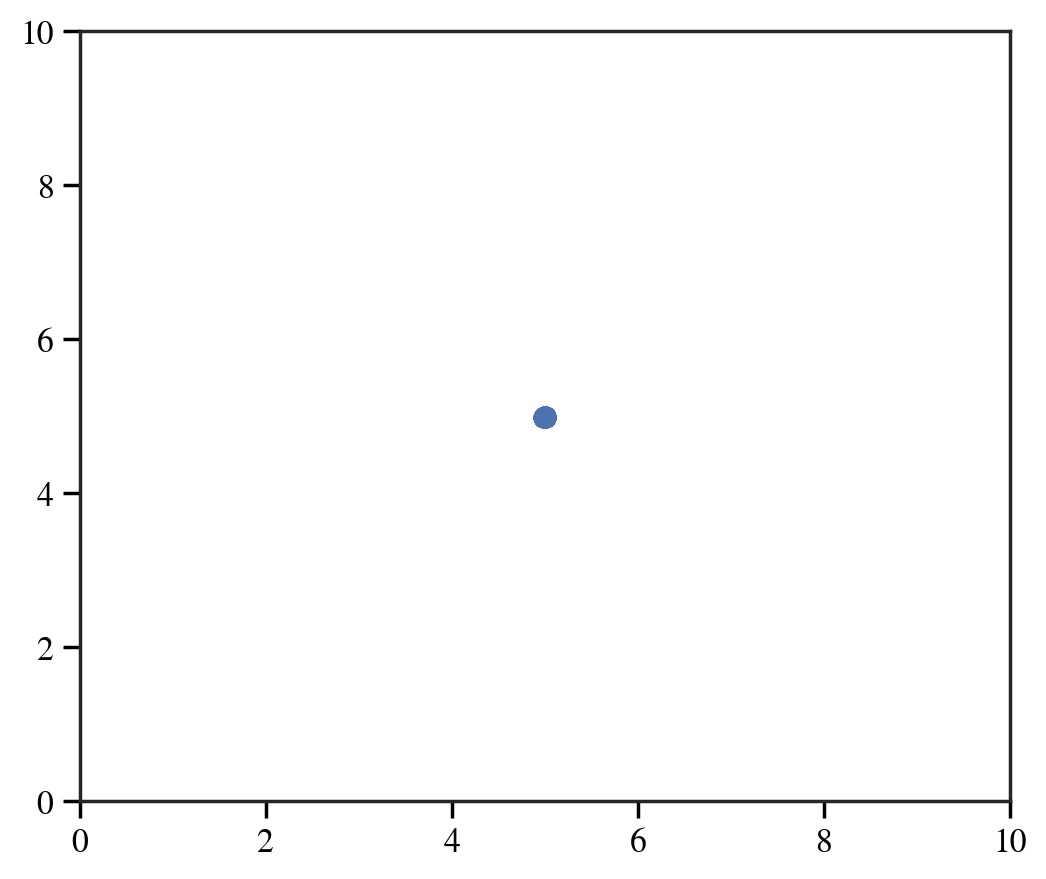

In [7]:
plt.scatter(
    totalPositionX[:, 1, 0] - 3 / model.omegaTheta[1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 / model.omegaTheta[1] * np.cos(totalPhaseTheta[:, 1])
)
plt.xlim(0, 10)
plt.ylim(0, 10)

(0.0, 10.0)

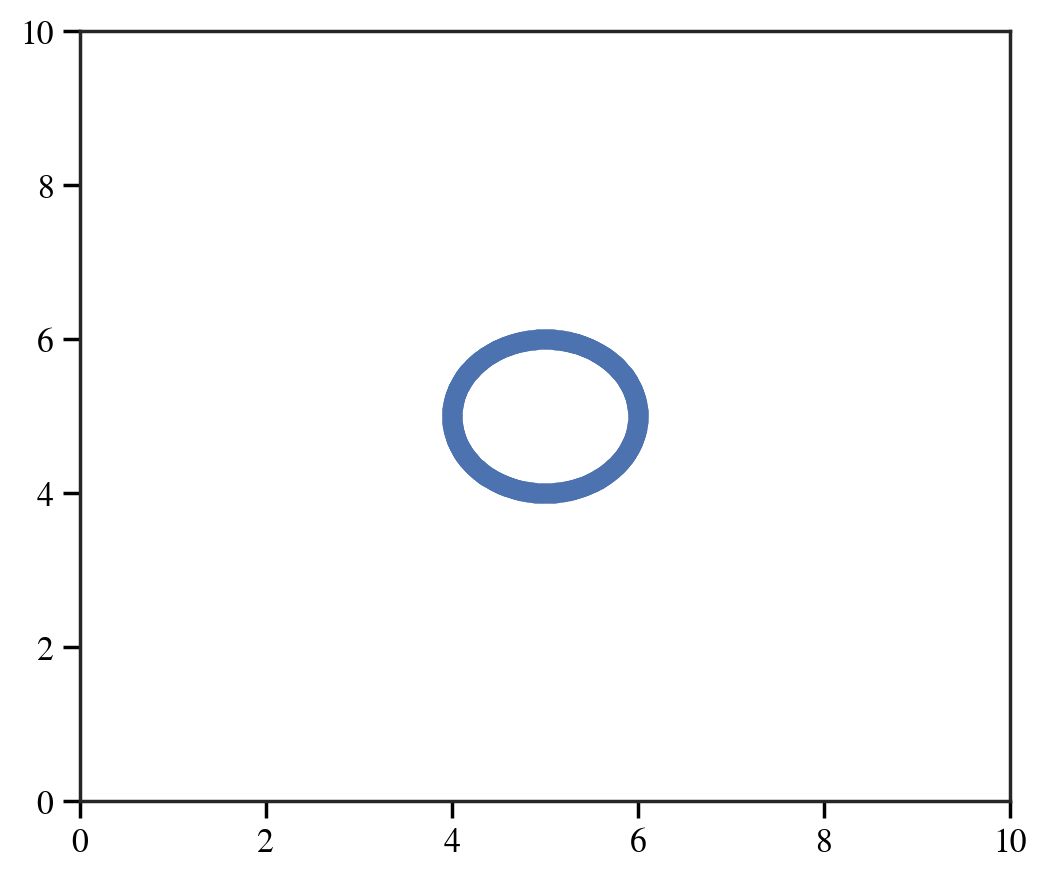

In [6]:
t = np.linspace(0, 10, 1000)
theta0 = np.pi / 2
omega = 3
v = 3
plt.scatter(5 + v / omega * np.sin(theta0 + omega * t), 
            5 - v / omega * np.cos(theta0 + omega * t))
plt.xlim(0, 10)
plt.ylim(0, 10)

In [185]:
from sympy import symbols, Eq, Function, dsolve, cos, sin

t, v, omega = symbols('t v omega')
x = symbols('x', cls=Function)(t)
y = symbols('y', cls=Function)(t)

eq1 = Eq(x.diff(t), v * cos(omega * t))
eq2 = Eq(y.diff(t), v * sin(omega * t))

solutions = dsolve([eq1, eq2])

for solution in solutions:
    display(solution)

Eq(x(t), C1 + v*Piecewise((sin(omega*t)/omega, Ne(omega, 0)), (t, True)))

Eq(y(t), C2 + v*Piecewise((-cos(omega*t)/omega, Ne(omega, 0)), (0, True)))

In [124]:
model = TwoOsillators(strengthLambda=3, distanceD0=0.5, omega1=3, omega2=-3,
                      couplesNum=1, savePath="./data", overWrite=True)
model.run(1030)

targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

(0.0, 10.0)

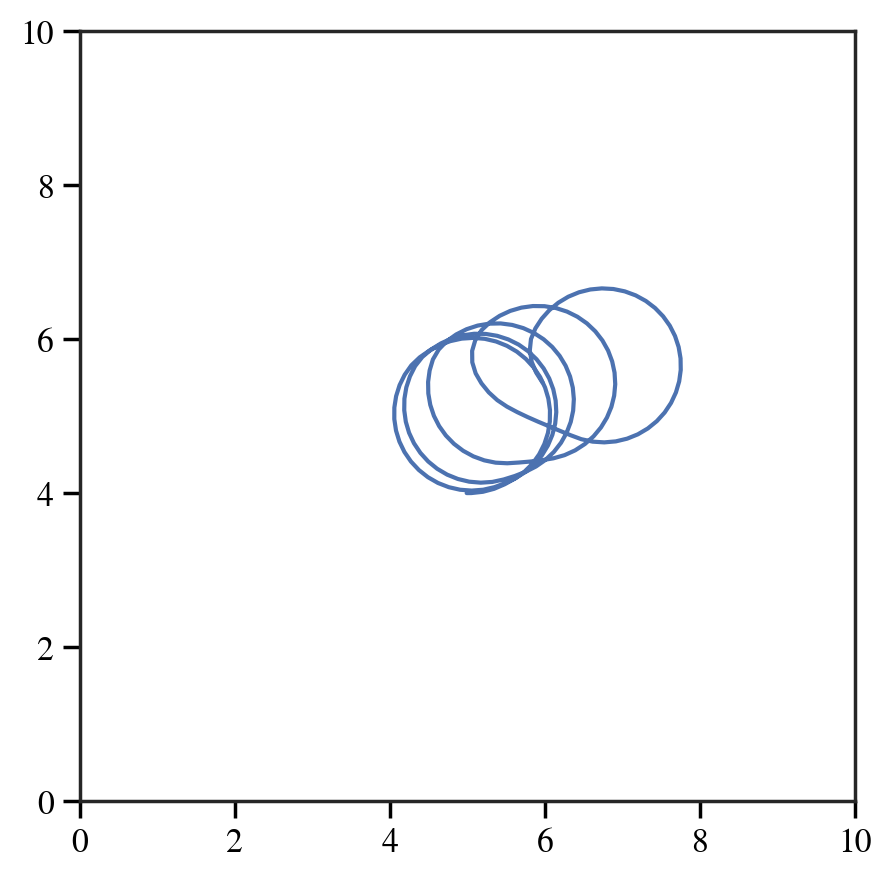

In [125]:
plt.figure(figsize=(5, 5))
plt.plot(totalPositionX[:, 0, 0], totalPositionX[:, 0, 1])# - 5
plt.xlim(0, 10)
plt.ylim(0, 10)

In [126]:
position = totalPositionX[:, 0] - 5
phaseTheta = totalPhaseTheta[:, 0]
spatialAngle = np.arctan2(position[:, 1], position[:, 0])

In [6]:
from sympy import symbols, Matrix, Eq

a11, a12, a21, a22 = symbols('a11 a12 a21 a22')
A = Matrix([[a11, a12], [a21, a22]])
b1, b2 = symbols('b1 b2')
B = Matrix([b1, b2])
x1, x2 = symbols('x1 x2')
X = Matrix([x1, x2])

# solve
eq = Eq(A * X, B)
solution = A.inv() * B
solution

Matrix([
[-a12*b2/(a11*a22 - a12*a21) + a22*b1/(a11*a22 - a12*a21)],
[ a11*b2/(a11*a22 - a12*a21) - a21*b1/(a11*a22 - a12*a21)]])